In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import the sequence file

In [ ]:
#change the file path name
human_data = pd.read_table('/content/human.txt')


In [ ]:
human_data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


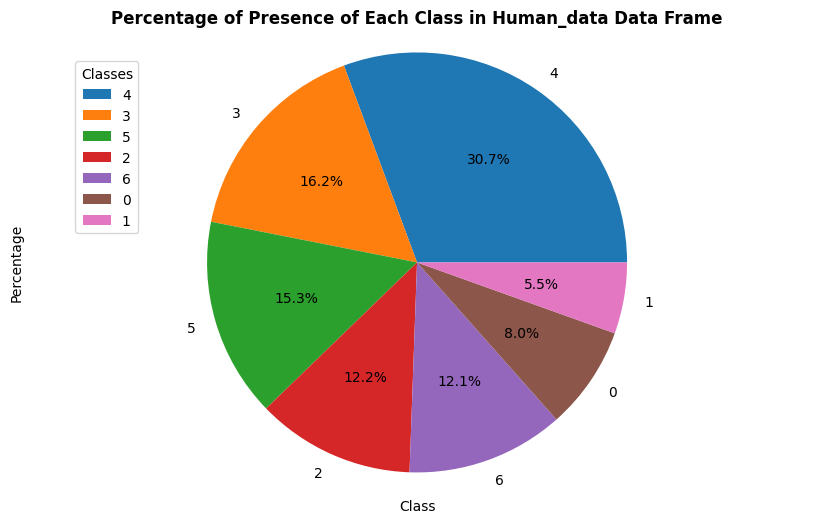

In [ ]:
# Get the unique classes
classes = human_data['class'].unique()

# Count the number of sequences in each class
class_counts = human_data['class'].value_counts()
# Calculate the percentage of the presence of each class
class_percentages = class_counts / class_counts.sum() * 100

# Create a pie chart of the class percentages
plt.figure(figsize=(10, 6))
plt.pie(class_percentages, labels=classes, autopct="%1.1f%%")

# Customize the pie chart design
plt.title("Percentage of Presence of Each Class in Human_data Data Frame", fontweight="bold")
plt.xlabel("Class")
plt.ylabel("Percentage")
plt.axis("equal")  # Equal aspect ratio ensures that the pie chart is circular.
plt.legend(title="Classes", loc="upper left", bbox_to_anchor=(0.05, 0.95))

# Set the pie chart colors
plt.gca().set_prop_cycle(plt.cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']))

# Add a grid
plt.grid(True, color='lightgray', linestyle='--')

# Display the pie chart
plt.show()

In [ ]:
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [ ]:
human_data['words'] = human_data.apply(lambda x: getKmers(x['sequence']), axis=1)
human_data = human_data.drop('sequence', axis=1)

KeyError: 'sequence'

In [ ]:
human_data.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


Since we are going to use scikit-learn natural language processing tools to do the k-mer counting, we need to now convert the lists of k-mers for each gene into string sentences of words that the count vectorizer can use. We can also make a y variable to hold the class labels. Let's do that now.

In [ ]:
human_texts = list(human_data['words'])
for item in range(len(human_texts)):
    human_texts[item] = ' '.join(human_texts[item])
y_data = human_data.iloc[:, 0].values

In [ ]:
print(human_texts[2])

atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggcatt gcattt catttg atttgg tttggg ttgggc tgggcg gggcgc ggcgct gcgctg cgctgt gctgtt ctgttt tgtttg gtttgg tttggc ttggca tggcag ggcagt gcagtg cagtga agtgat gtgatg tgatga gatgat atgatt tgattg gattgc attgcc ttgcct tgcctt gccttt cctttc ctttct tttctg ttctgt tctgtt ctgttc tgttca gttcag ttcagt tcagtg cagtgt agtgtc gtgtct tgtctg gtctga tctgag ctgagt tgagtg gagtgc agtgct gtgcta tgctat gctatg ctatga tatgaa atgaag tgaaga gaagat aagatt agattg gattgc attgca ttgcac tgcaca gcacac cacaca acacag cacaga acagag cagagg agaggt gaggtc aggtcc ggtcca gtccag tccaga ccagat cagatg agatgc gatgca atgcat tgcatt gcattc cattcc attccg ttccgt tccgtt ccgttt cgtttt gttttg ttttga tttgag ttgaga tgagaa gagaat agaatg gaatgt aatgtc atgtca tgtcaa gtcaat tcaatg caatgg aatgga atggat tggata ggatac gataca atacac tacacc acacca caccaa accaac ccaact caactg aactgc actgct ctgctg tgctgc gctgct ctgctt tgcttt gctttg ctttgg tttgga ttggat tggatt ggattt gatttc atttca tttcac ttcacc tcaccg caccgg accggt

In [ ]:
y_data

array([4, 4, 3, ..., 6, 6, 6])

In [ ]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
X = cv.fit_transform(human_texts)

In [ ]:
print(X.shape)

(4380, 232414)


If we have a look at class balance we can see we have relatively balanced dataset.

<Axes: >

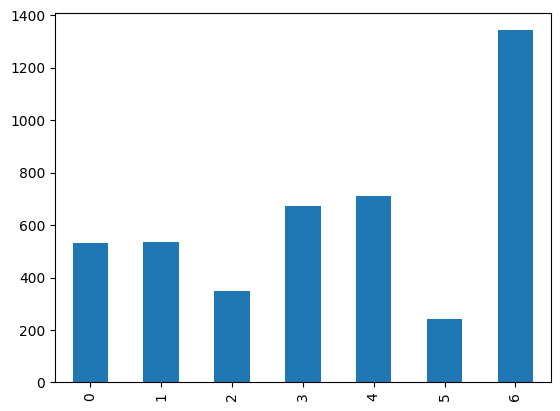

In [ ]:
human_data['class'].value_counts().sort_index().plot.bar()

In [ ]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y_data,
                                                    test_size = 0.20,
                                                    random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(3504, 232414)
(876, 232414)


A multinomial naive Bayes classifier will be created.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

In [ ]:
y_pred = classifier.predict(X_test)

Okay, so let's look at some model performce metrics like the confusion matrix, accuracy, precision, recall and f1 score.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted   0    1   2    3    4   5    6
Actual                                   
0          99    0   0    0    1   0    2
1           0  104   0    0    0   0    2
2           0    0  78    0    0   0    0
3           0    0   0  124    0   0    1
4           1    0   0    0  143   0    5
5           0    0   0    0    0  51    0
6           1    0   0    1    0   0  263
accuracy = 0.984 
precision = 0.984 
recall = 0.984 
f1 = 0.984
